# TD 6

[Use pytorch for all questions]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
from torch.utils.data import DataLoader, Dataset

c:\__APP__\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RNN: Determinating Lastnames Origins

The goal here is to build our first (basic) RNN network.

We have a datset composed of 18000 names, from 18 nationalities (1000 names from each country).
We try to build a network to classify names to their correct nationality.
We do that with a RNN, that "reads" each letter one by one.

Link to the dataset *name_1000*, containing 1000 names from 18 nationalities:
https://drive.google.com/drive/folders/1qqyB_ZRMsz_7veqlKYnJH2kmYK6myV4Y?usp=share_link

Start by downloading it and store it in your working directory.

### Pre-processing

Some countries are using non-latin alphabet, we need the ASCII version.
You can try the function `unidecode` from the `unidecode` mdule.

Create a function that takes a name, and return its version using only letters from 
`LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'` (you can add some letters if you want, but the more you add, the more complex your network will become).

Test your function on `'Ślusàrski'`, `'François'`, `'北亰'`, `'Kožušček'`, and `'+-*/'`.

In [2]:
from unidecode import unidecode
unidecode('Ślusàrski'), unidecode('François'), unidecode('北亰'), unidecode('Kožušček'), unidecode('+-*/')

('Slusarski', 'Francois', 'Bei Jing ', 'Kozuscek', '+-*/')

In [3]:
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ -'
N_LETTERS = len(LETTERS)

def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

unicodeToAscii('Ślusàrski'), unicodeToAscii('François'), unicodeToAscii('北亰'), unicodeToAscii('kožušček'), unicodeToAscii('+-*/')

('Slusarski', 'Francois', 'Bei Jing ', 'kozuscek', '-')

### Feeding letters to a network

A network can not, originally, process characters/letters; networks can only understand numbers, and list of numbers.
We need to turn our characters to a vector. We could just take the binary byte representing the character in the ASCII. However, this would be very hard for the network to understand (`x: 1011000`,s `y:1011001` and `z: 1011010` will have very similar activations).
Thus, we will use 'one-hot encoding' of our set of letters `LETTERS`. That is, we transform each letter to a tensor of size `<1xN_LETTERS>`, where all entries are zero except the one corresponding to the position of the letter, that we set to one.
e.g.:
- `a => [1, 0, 0, 0, ..., 0]`
- `b => [0, 1, 0, 0, ..., 0]`
- `c => [0, 0, 1, 0, ..., 0]`

Define a `letterToTensor` function that perfoms this operation.

In [4]:
# Turn a letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][LETTERS.find(letter)] = 1
    return tensor

letterToTensor('a'), letterToTensor('b'), letterToTensor('c')

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

Now define a `nameToTensor` function that perfoms this operation for each letter in the name (resulting to a `<name_length x 1 x N_LETTERS>` tensor).

In [5]:
# Turn a name into a <name_length x 1 x N_LETTERS> tensor
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

nameToTensor('abc'), nameToTensor('abc').shape

(tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]],
 
         [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0.]]]),
 torch.Size([3, 1, 54]))

Create a custom dataset:
- in the `__init__`, read all files, and create a list of names and associated country
- add a `countryID` method that turns a country its index
- add a `countryTensor` method that turns a country to a one-hot encoded tensor
- the `__getitem__` should return one piece of data in the form `(name, country, nameTensor, countryID)`

### Loading data

In [6]:
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
        print(f'Loaded {self.n} names from {self.n_countries} countries')
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names_1000/*.txt')
N_COUNTRIES = dataset.n_countries
dataset[0][0], dataset[0][1], dataset[0][2].shape, dataset[0][3]

Loaded 18000 names from 18 countries


('Handal', 'Arabic', torch.Size([6, 1, 54]), tensor(0))

Create a dataloader for the dataset; the `batch_size` must be 1, since different names can have different lengths (and therefore, different tensor size).

In [7]:
loader = DataLoader(dataset, batch_size=1, shuffle=True) # batch_size 1 as names have different lengths

loader.dataset[0][0], loader.dataset[0][1],\
loader.dataset[0][2].shape, loader.dataset[0][3]

('Handal', 'Arabic', torch.Size([6, 1, 54]), tensor(0))

### Build the RNN

Define the RNN with the following parameters:
- input_size: number of input features
- hidden_size: number of hidden units
- output_size: number of output features
- idx_to_country: list of countries

The input is a one-hot vector of size `N_LETTERS`; the output is a one-hot vector of size `N_COUNTRIES = len(idx_to_country)` + a hidden state of size `hidden_size`.
You can build the architecture you like, but one that is known to work is the following:

<svg
   width="180mm"
   height="150mm"
   viewBox="0 0 250 230"
   version="1.1"
   id="svg5"
   xml:space="preserve"
   inkscape:version="1.2.1 (9c6d41e410, 2022-07-14)"
   sodipodi:docname="rnn.svg"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><sodipodi:namedview
     id="namedview7"
     pagecolor="#ffffff"
     bordercolor="#000000"
     borderopacity="0.25"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1"
     inkscape:document-units="mm"
     showgrid="false"
     inkscape:zoom="0.7071068"
     inkscape:cx="753.0687"
     inkscape:cy="376.8879"
     inkscape:window-width="1920"
     inkscape:window-height="991"
     inkscape:window-x="4791"
     inkscape:window-y="-9"
     inkscape:window-maximized="1"
     inkscape:current-layer="layer1" /><defs
     id="defs2"><inkscape:path-effect
       effect="skeletal"
       id="path-effect429"
       is_visible="true"
       lpeversion="1"
       pattern="M 0,4.9921385 C 0,2.2364781 2.2364781,0 4.9921385,0 7.747799,0 9.984277,2.2364781 9.984277,4.9921385 9.984277,7.747799 7.747799,9.984277 4.9921385,9.984277 2.2364781,9.984277 0,7.747799 0,4.9921385 Z"
       copytype="single_stretched"
       prop_scale="1"
       scale_y_rel="false"
       spacing="0"
       normal_offset="0"
       tang_offset="0"
       prop_units="false"
       vertical_pattern="false"
       hide_knot="false"
       fuse_tolerance="0" /><inkscape:path-effect
       effect="spiro"
       id="path-effect423"
       is_visible="true"
       lpeversion="1" /><inkscape:path-effect
       effect="spiro"
       id="path-effect419"
       is_visible="true"
       lpeversion="1" /><inkscape:path-effect
       effect="powerstroke"
       id="path-effect413"
       is_visible="true"
       lpeversion="1"
       offset_points="0,4.9921385"
       not_jump="false"
       sort_points="true"
       interpolator_type="CubicBezierJohan"
       interpolator_beta="0.2"
       start_linecap_type="zerowidth"
       linejoin_type="extrp_arc"
       miter_limit="4"
       scale_width="1"
       end_linecap_type="zerowidth" /></defs><g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1"><g
       id="g3039"
       transform="matrix(1.4682178,0,0,1.4682178,-40.502839,-12.441842)"><path
         style="fill:#000000;fill-opacity:1;stroke:#707070;stroke-width:3.95694;stroke-linecap:round;stroke-linejoin:round;stroke-dasharray:none;stroke-opacity:1"
         d="m 154.93054,40.952583 22.99511,-0.23014"
         id="path2785" /><path
         style="fill:#000000;fill-opacity:1;stroke:#707070;stroke-width:3.95694;stroke-linecap:round;stroke-linejoin:round;stroke-dasharray:none;stroke-opacity:1"
         d="m 156.77744,52.695251 22.99511,-0.23014"
         id="path2785-7" /></g><g
       id="g2456"
       transform="matrix(1.4682178,0,0,1.4682178,-40.502839,-12.441842)"><path
         d="m 57.107868,18.211057 c 9.227887,2.476855 31.397873,8.428583 40.969429,10.998057"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8"
         sodipodi:nodetypes="cc" /><path
         d="m 57.107868,29.73927 c 9.227887,2.476854 31.397873,8.428583 40.969429,10.998056"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-8"
         sodipodi:nodetypes="cc" /><path
         d="m 57.107868,41.267479 c 9.227887,2.476854 31.397873,8.428583 40.969429,10.998056"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-89"
         sodipodi:nodetypes="cc" /><path
         d="m 57.107868,52.795691 c 9.227887,2.476854 31.397873,8.428583 40.969429,10.998056"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1"
         sodipodi:nodetypes="cc" /><path
         d="m 55.620229,84.429049 c 9.879944,-1.894885 33.616493,-6.448185 43.864391,-8.41393"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6"
         sodipodi:nodetypes="cc" /><path
         d="M 55.620229,96.088491 C 65.500174,94.193605 89.236723,89.640302 99.48462,87.67456"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6-4"
         sodipodi:nodetypes="cc" /><path
         d="m 55.620229,107.74793 c 9.879945,-1.89489 33.616494,-6.44819 43.864391,-8.413931"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6-8"
         sodipodi:nodetypes="cc" /><path
         d="m 55.620229,119.40737 c 9.879944,-1.89489 33.616493,-6.44819 43.864391,-8.41393"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6-44"
         sodipodi:nodetypes="cc" /><path
         d="m 55.620229,131.06681 c 9.879944,-1.89488 33.616493,-6.44818 43.864391,-8.41393"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6-81"
         sodipodi:nodetypes="cc" /><path
         d="m 55.620229,142.72625 c 9.879945,-1.89488 33.616494,-6.44818 43.864391,-8.41393"
         style="fill:none;stroke:#707070;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906-8-1-6-82"
         sodipodi:nodetypes="cc" /></g><g
       id="g2626"
       transform="matrix(1.4682178,0,0,1.4682178,-40.502839,-12.441842)"><path
         d="m 103.99351,77.017534 c 9.87443,2.275253 33.86986,7.804392 44.15201,10.173465"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7724" /><path
         d="m 102.88525,77.519249 c 9.42931,4.364652 36.70885,16.993638 46.50758,21.529733"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7732" /><path
         d="m 102.13021,77.750896 c 8.87459,6.171363 38.82078,26.997334 48.07275,33.432284"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7740" /><path
         d="m 101.62292,77.861805 c 8.3567,7.754132 40.53737,37.616665 49.18071,45.636955"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7748" /><path
         d="m 102.13021,74.26324 c 8.89551,-6.222849 38.95865,-27.257344 48.13726,-33.678669"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7756" /><path
         d="m 102.88525,74.491872 c 9.42931,-4.404413 36.70885,-17.147659 46.50758,-21.724745"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7764" /><path
         d="m 103.99351,74.988785 c 9.89977,-2.322387 33.99065,-7.974608 44.2289,-10.376741"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7772" /><path
         d="m 104.74265,76.001372 c 10.03558,-0.0209 32.23694,-0.06713 42.63281,-0.08902"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7780" /><path
         d="m 104.74265,88.096251 c 10.03558,0.04189 32.23694,0.13526 42.63281,0.178482"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7788" /><path
         d="m 103.99351,89.107613 c 9.89977,2.343384 33.99065,8.046091 44.2289,10.469221"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7790" /><path
         d="m 102.88525,89.602402 c 9.42931,4.42396 36.70885,17.224388 46.50758,21.822028"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7792" /><path
         d="m 102.13021,89.829245 c 8.89551,6.241614 38.95865,27.338885 48.13726,33.779525"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7794" /><path
         d="m 101.62292,86.229787 c 8.3567,-7.736706 40.53737,-37.531556 49.18071,-45.533974"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7796" /><path
         d="m 102.13021,86.341478 c 8.87459,-6.15293 38.82078,-26.916131 48.07275,-33.331313"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7798" /><path
         d="m 102.96567,86.537833 c 9.4847,-4.370797 36.55478,-16.845648 46.37178,-21.370016"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7800" /><path
         d="m 103.99351,87.078415 c 9.87443,-2.254254 33.86986,-7.733245 44.15201,-10.080539"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7802" /><path
         d="m 104.08424,99.1485 c 9.91156,-2.200756 33.72404,-7.48775 44.00473,-9.770821"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7810" /><path
         d="m 104.74265,100.19113 c 10.03558,0.10521 32.23694,0.33776 42.63281,0.44643"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7812" /><path
         d="m 103.99351,101.19769 c 9.89977,2.40526 33.99065,8.25942 44.2289,10.74722"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7814" /><path
         d="m 102.88525,101.68544 c 9.45111,4.49388 36.84024,17.51714 46.57769,22.1475"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7816" /><path
         d="m 101.28443,98.231743 c 7.89302,-9.093191 41.67568,-48.014738 49.87006,-57.455288"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7818" /><path
         d="m 101.65503,98.275412 c 8.40855,-7.731903 40.52706,-37.268075 49.15332,-45.199796"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7820" /><path
         d="m 102.13021,98.419828 c 8.87459,-6.097196 38.82078,-26.671862 48.07275,-33.029524"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7822" /><path
         d="m 102.96567,98.621431 c 9.4847,-4.31104 36.55478,-16.615787 46.37178,-21.078614"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7824" /><path
         d="m 102.96567,110.70492 c 9.4847,-4.25162 36.55478,-16.386263 46.37178,-20.787102"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7832" /><path
         d="m 104.08424,111.23902 c 9.91156,-2.13832 33.72404,-7.27609 44.00473,-9.49416"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7834" /><path
         d="m 104.74265,112.28568 c 10.03558,0.16832 32.23694,0.54047 42.63281,0.71459"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7836" /><path
         d="m 103.90365,113.26554 c 9.86089,2.45764 34.13824,8.50949 44.37533,11.06129"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7838" /><path
         d="M 101.02902,110.27212 C 108.49753,99.978696 143.62058,51.567345 151.4158,40.823141"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7840" /><path
         d="m 101.28443,110.30484 c 7.89302,-9.04349 41.67568,-47.752597 49.87006,-57.141993"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7842" /><path
         d="m 101.65503,110.35064 c 8.38911,-7.66166 40.38212,-36.880625 49.09351,-44.836807"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7844" /><path
         d="m 102.20179,110.44926 c 8.96651,-6.10368 38.79869,-26.413078 48.01384,-32.686523"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7846" /><path
         d="m 102.20179,122.52805 c 8.94589,-6.03353 38.66053,-26.076323 47.94932,-32.341505"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7854" /><path
         d="m 103.04757,122.75267 c 9.5386,-4.21588 36.39924,-16.08828 46.23479,-20.43539"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7856" /><path
         d="m 104.08424,123.32955 c 9.91156,-2.07589 33.72404,-7.06411 44.00473,-9.21762"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7858" /><path
         d="m 104.74265,124.38056 c 10.03558,0.2312 32.23694,0.74296 42.63281,0.98254"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7860" /><path
         d="m 100.84372,122.31506 c 7.11529,-11.4168 43.35103,-69.557539 50.77593,-81.472261"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7862" /><path
         d="m 101.05671,122.3059 c 7.52713,-10.32737 42.58362,-58.425989 50.36262,-69.099048"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7864" /><path
         d="m 101.31448,122.34388 c 7.93897,-9.04695 41.59142,-47.394857 49.81703,-56.767723"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7866" /><path
         d="m 101.65503,122.42597 c 8.38911,-7.60893 40.38212,-36.626748 49.09351,-44.528423"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7868" /><path
         d="m 101.68832,134.47193 c 8.43978,-7.60234 40.37181,-36.364052 49.06464,-44.19458"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7876" /><path
         d="m 102.20179,134.60674 c 8.94589,-5.97713 38.66053,-25.83329 47.94932,-32.03995"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7878" /><path
         d="m 103.04757,134.83671 c 9.5386,-4.15612 36.39924,-15.85964 46.23479,-20.14488"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7880" /><path
         d="m 104.17645,135.40164 c 9.94808,-2.02127 33.57645,-6.82229 43.85625,-8.9108"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7882" /><path
         d="m 100.71941,134.33109 c 6.8528,-12.54567 43.94491,-80.453646 51.05314,-93.466847"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7884" /><path
         d="m 100.87024,134.34415 c 7.17715,-11.47097 43.34189,-69.272723 50.75265,-81.116298"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7886" /><path
         d="m 101.05671,134.37766 c 7.52713,-10.28024 42.58362,-58.15849 50.36262,-68.782738"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7888" /><path
         d="m 101.31448,134.41698 c 7.93897,-8.99725 41.59142,-47.133501 49.81703,-56.454428"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7890" /><path
         d="m 101.31448,29.457378 c 7.93897,9.046951 41.59142,47.394854 49.81703,56.767606"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7898" /><path
         d="m 101.05671,29.495352 c 7.52713,10.327375 42.58362,58.425992 50.36262,69.099051"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7900" /><path
         d="m 100.84372,29.486082 c 7.11529,11.416916 43.35103,69.557651 50.77593,81.472378"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7902" /><path
         d="m 100.69525,29.495352 c 6.79654,12.48401 44.03241,80.890688 51.09791,93.869488"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7904" /><path
         d="m 104.08424,28.471706 c 9.91156,2.075885 33.72404,7.064106 44.00473,9.217616"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7906"
         sodipodi:nodetypes="cc" /><path
         d="m 103.04757,29.048589 c 9.5386,4.215879 36.39924,16.088161 46.23479,20.435389"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7908" /><path
         d="m 102.20179,29.273201 c 8.94589,6.033532 38.66053,26.076326 47.94932,32.341509"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7910" /><path
         d="m 101.65503,29.375286 c 8.38911,7.608931 40.38212,36.626747 49.09351,44.528422"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7912" /><path
         d="m 101.65503,41.450618 c 8.38911,7.661652 40.38212,36.880625 49.09351,44.836803"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7920" /><path
         d="m 101.28443,41.496412 c 7.89302,9.043376 41.67568,47.7526 49.87006,57.141996"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7922" /><path
         d="m 101.02902,41.529139 c 7.46851,10.29342 42.59156,58.704771 50.38678,69.448971"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7924" /><path
         d="m 100.84372,41.556614 c 7.11529,11.461371 43.35103,69.829846 50.77593,81.791246"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7926" /><path
         d="m 104.74265,39.515578 c 10.03558,-0.16832 32.23694,-0.540472 42.63281,-0.714597"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7928" /><path
         d="m 104.08424,40.562231 c 9.91156,2.13832 33.72404,7.276095 44.00473,9.49416"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7930" /><path
         d="m 102.96567,41.096336 c 9.4847,4.25162 36.55478,16.386261 46.37178,20.7871"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7932" /><path
         d="m 102.20179,41.351996 c 8.96651,6.103676 38.79869,26.413076 48.01384,32.686522"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7934" /><path
         d="m 102.13021,53.381427 c 8.87459,6.097199 38.82078,26.671862 48.07275,33.029524"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7942" /><path
         d="m 101.65503,53.525843 c 8.40855,7.731902 40.52706,37.268078 49.15332,45.199795"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7944" /><path
         d="m 101.28443,53.569401 c 7.89302,9.093302 41.67568,48.014849 49.87006,57.455399"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7946" /><path
         d="m 101.02902,53.60045 c 7.47646,10.351837 42.66875,59.07961 50.4121,69.80102"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7948" /><path
         d="m 103.99351,50.603565 c 9.89977,-2.405261 33.99065,-8.259418 44.2289,-10.747221"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7950" /><path
         d="m 104.74265,51.610121 c 10.03558,-0.105211 32.23694,-0.337753 42.63281,-0.446427"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7952" /><path
         d="m 104.08424,52.652754 c 9.91156,2.200757 33.72404,7.487751 44.00473,9.770821"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7954" /><path
         d="m 102.96567,53.179823 c 9.4847,4.311041 36.55478,16.615787 46.37178,21.078614"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7956" /><path
         d="m 103.21195,65.481109 c 9.71359,4.455792 36.4776,16.733956 46.17293,21.181481"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7964" /><path
         d="m 102.34791,65.716665 c 9.14621,6.322367 38.75273,26.787463 47.8907,33.104581"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7966" /><path
         d="m 101.81971,65.860634 c 8.64216,7.983321 40.33028,37.255456 48.95299,45.220796"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7968" /><path
         d="m 101.43527,65.924858 c 8.15873,9.433847 41.55371,48.047462 49.71127,57.480532"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7970" /><path
         d="m 103.12917,62.189247 c 9.66057,-4.553521 36.63314,-17.265828 46.30961,-21.826831"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7972" /><path
         d="m 104.36175,62.70805 c 10.11836,-2.416206 33.75821,-8.061392 43.86773,-10.475363"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7974" /><path
         d="m 105.13593,63.803515 c 10.21764,-0.06411 32.0048,-0.201044 42.25926,-0.265713"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7976" /><path
         d="m 104.45602,64.929579 c 10.15194,2.296697 33.61003,7.603795 43.71808,9.890329"
         style="fill:none;stroke:#707070;stroke-width:0.181393;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path7978" /></g><path
       d="m 41.496589,6.1831395 c 4.051444,0 7.335877,3.2844326 7.335877,7.3358705 0,4.051445 -3.284433,7.335877 -7.335877,7.335877 -4.051444,0 -7.335877,-3.284432 -7.335877,-7.335877 0,-4.0514379 3.284433,-7.3358705 7.335877,-7.3358705"
       style="fill:#2ecc71;fill-opacity:1;fill-rule:nonzero;stroke:#219150;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,39.348014 c 4.051442,0 7.335879,3.284433 7.335879,7.335877 0,4.051444 -3.284437,7.335877 -7.335879,7.335877 -4.051441,0 -7.335878,-3.284433 -7.335878,-7.335877 0,-4.051444 3.284437,-7.335877 7.335878,-7.335877"
       style="fill:#2ecc71;fill-opacity:1;fill-rule:nonzero;stroke:#219150;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,22.765576 c 4.051442,0 7.335879,3.284433 7.335879,7.335877 0,4.051444 -3.284437,7.335877 -7.335879,7.335877 -4.051441,0 -7.335878,-3.284433 -7.335878,-7.335877 0,-4.051444 3.284437,-7.335877 7.335878,-7.335877"
       style="fill:#2ecc71;fill-opacity:1;fill-rule:nonzero;stroke:#219150;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-0"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,55.930453 c 4.051443,0 7.335879,3.284433 7.335879,7.335877 0,4.051444 -3.284436,7.335877 -7.335879,7.335877 -4.051441,0 -7.335877,-3.284433 -7.335877,-7.335877 0,-4.051444 3.284436,-7.335877 7.335877,-7.335877"
       style="fill:#2ecc71;fill-opacity:1;fill-rule:nonzero;stroke:#219150;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,103.28474 c 4.051446,0 7.335879,3.28443 7.335879,7.33587 0,4.05144 -3.284433,7.33588 -7.335879,7.33588 -4.051444,0 -7.335877,-3.28444 -7.335877,-7.33588 0,-4.05144 3.284433,-7.33587 7.335877,-7.33587"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-6"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,137.62877 c 4.051443,0 7.335879,3.28443 7.335879,7.33587 0,4.05145 -3.284436,7.33588 -7.335879,7.33588 -4.051441,0 -7.335877,-3.28443 -7.335877,-7.33588 0,-4.05144 3.284436,-7.33587 7.335877,-7.33587"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,120.45675 c 4.051443,0 7.335879,3.28443 7.335879,7.33587 0,4.05145 -3.284436,7.33589 -7.335879,7.33589 -4.051441,0 -7.335877,-3.28444 -7.335877,-7.33589 0,-4.05144 3.284436,-7.33587 7.335877,-7.33587"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-0-1"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,154.80078 c 4.051443,0 7.335879,3.28443 7.335879,7.33587 0,4.05145 -3.284436,7.33588 -7.335879,7.33588 -4.051441,0 -7.335877,-3.28443 -7.335877,-7.33588 0,-4.05144 3.284436,-7.33587 7.335877,-7.33587"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,171.97279 c 4.051443,0 7.335879,3.28443 7.335879,7.33588 0,4.05144 -3.284436,7.33587 -7.335879,7.33587 -4.051441,0 -7.335877,-3.28443 -7.335877,-7.33587 0,-4.05145 3.284436,-7.33588 7.335877,-7.33588"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8-4"
       sodipodi:nodetypes="csssc" /><path
       d="m 41.496589,189.1448 c 4.051443,0 7.335879,3.28443 7.335879,7.33588 0,4.05144 -3.284436,7.33587 -7.335879,7.33587 -4.051441,0 -7.335877,-3.28443 -7.335877,-7.33587 0,-4.05145 3.284436,-7.33588 7.335877,-7.33588"
       style="fill:#3498db;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.5;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2-2"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,22.939852 c 4.05145,0 7.33589,3.284433 7.33589,7.335871 0,4.051444 -3.28444,7.335877 -7.33589,7.335877 -4.05144,0 -7.335874,-3.284433 -7.335874,-7.335877 0,-4.051438 3.284434,-7.335871 7.335874,-7.335871"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-8"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,57.421434 c 4.05145,0 7.33589,3.284433 7.33589,7.335877 0,4.051445 -3.28444,7.335877 -7.33589,7.335877 -4.05144,0 -7.335874,-3.284432 -7.335874,-7.335877 0,-4.051444 3.284434,-7.335877 7.335874,-7.335877"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-4"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,40.180642 c 4.05145,0 7.33589,3.284432 7.33589,7.335877 0,4.051444 -3.28444,7.335876 -7.33589,7.335876 -4.05144,0 -7.335874,-3.284432 -7.335874,-7.335876 0,-4.051445 3.284434,-7.335877 7.335874,-7.335877"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-0-7"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,74.662229 c 4.05145,0 7.33589,3.284432 7.33589,7.335876 0,4.051445 -3.28444,7.335877 -7.33589,7.335877 -4.05144,0 -7.335874,-3.284432 -7.335874,-7.335877 0,-4.051444 3.284434,-7.335876 7.335874,-7.335876"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-23"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,91.903024 c 4.05145,0 7.33589,3.284433 7.33589,7.335871 0,4.051445 -3.28444,7.335875 -7.33589,7.335875 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.335875 0,-4.051438 3.284434,-7.335871 7.335874,-7.335871"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-6-2"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,126.38461 c 4.05145,0 7.33589,3.28443 7.33589,7.33588 0,4.05144 -3.28444,7.33587 -7.33589,7.33587 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.33587 0,-4.05145 3.284434,-7.33588 7.335874,-7.33588"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8-7"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,109.14381 c 4.05145,0 7.33589,3.28444 7.33589,7.33588 0,4.05145 -3.28444,7.33588 -7.33589,7.33588 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.33588 0,-4.05144 3.284434,-7.33588 7.335874,-7.33588"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-0-1-9"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,143.62541 c 4.05145,0 7.33589,3.28443 7.33589,7.33588 0,4.05144 -3.28444,7.33587 -7.33589,7.33587 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.33587 0,-4.05145 3.284434,-7.33588 7.335874,-7.33588"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2-7"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,160.86619 c 4.05145,0 7.33589,3.28443 7.33589,7.33588 0,4.05144 -3.28444,7.33587 -7.33589,7.33587 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.33587 0,-4.05145 3.284434,-7.33588 7.335874,-7.33588"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8-4-0"
       sodipodi:nodetypes="csssc" /><path
       d="m 106.07951,178.10699 c 4.05145,0 7.33589,3.28443 7.33589,7.33587 0,4.05145 -3.28444,7.33588 -7.33589,7.33588 -4.05144,0 -7.335874,-3.28443 -7.335874,-7.33588 0,-4.05144 3.284434,-7.33587 7.335874,-7.33587"
       style="fill:#ffdd55;fill-opacity:1;fill-rule:nonzero;stroke:#aa8800;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2-2-4"
       sodipodi:nodetypes="csssc" /><g
       id="g3031"
       transform="matrix(1.4682178,0,0,1.4682178,-40.502839,-12.441842)"
       style="fill:#ff2a2a;stroke:#aa0000"><path
         d="m 152.60023,35.841062 c 2.75944,0 4.99646,2.23702 4.99646,4.996451 0,2.75943 -2.23702,4.99645 -4.99646,4.99645 -2.75943,0 -4.99645,-2.23702 -4.99645,-4.99645 0,-2.759431 2.23702,-4.996451 4.99645,-4.996451"
         style="fill:#ff2a2a;fill-opacity:1;fill-rule:nonzero;stroke:#aa0000;stroke-width:1;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path210-3-4-8"
         sodipodi:nodetypes="csssc" /><path
         d="m 152.60023,47.583731 c 2.75944,0 4.99646,2.23702 4.99646,4.99645 0,2.75943 -2.23702,4.99645 -4.99646,4.99645 -2.75943,0 -4.99645,-2.23702 -4.99645,-4.99645 0,-2.75943 2.23702,-4.99645 4.99645,-4.99645"
         style="fill:#ff2a2a;fill-opacity:1;fill-rule:nonzero;stroke:#aa0000;stroke-width:1;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path210-2-23-7"
         sodipodi:nodetypes="csssc" /></g><path
       d="m 183.54753,74.662233 c 4.05146,0 7.33589,3.284434 7.33589,7.335871 0,4.051444 -3.28443,7.335877 -7.33589,7.335877 -4.05144,0 -7.33588,-3.284433 -7.33588,-7.335877 0,-4.051437 3.28444,-7.33587 7.33588,-7.33587"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-6-2-8"
       sodipodi:nodetypes="csssc" /><path
       d="m 183.54753,109.14382 c 4.05146,0 7.33589,3.28443 7.33589,7.33588 0,4.05144 -3.28443,7.33588 -7.33589,7.33588 -4.05144,0 -7.33588,-3.28444 -7.33588,-7.33588 0,-4.05145 3.28444,-7.33588 7.33588,-7.33588"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8-7-5"
       sodipodi:nodetypes="csssc" /><path
       d="m 183.54753,91.903023 c 4.05146,0 7.33589,3.284432 7.33589,7.335877 0,4.05144 -3.28443,7.33588 -7.33589,7.33588 -4.05144,0 -7.33588,-3.28444 -7.33588,-7.33588 0,-4.051445 3.28444,-7.335877 7.33588,-7.335877"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-0-1-9-9"
       sodipodi:nodetypes="csssc" /><path
       d="m 183.54753,126.38462 c 4.05146,0 7.33589,3.28443 7.33589,7.33588 0,4.05143 -3.28443,7.33586 -7.33589,7.33586 -4.05144,0 -7.33588,-3.28443 -7.33588,-7.33586 0,-4.05145 3.28444,-7.33588 7.33588,-7.33588"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2-7-7"
       sodipodi:nodetypes="csssc" /><path
       d="m 183.54753,143.62539 c 4.05146,0 7.33589,3.28444 7.33589,7.33588 0,4.05144 -3.28443,7.33588 -7.33589,7.33588 -4.05144,0 -7.33588,-3.28444 -7.33588,-7.33588 0,-4.05144 3.28444,-7.33588 7.33588,-7.33588"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-3-8-4-0-9"
       sodipodi:nodetypes="csssc" /><path
       d="m 183.54753,160.86619 c 4.05146,0 7.33589,3.28443 7.33589,7.33588 0,4.05144 -3.28443,7.33587 -7.33589,7.33587 -4.05144,0 -7.33588,-3.28443 -7.33588,-7.33587 0,-4.05145 3.28444,-7.33588 7.33588,-7.33588"
       style="fill:#79bbe7;fill-opacity:1;fill-rule:nonzero;stroke:#1b6597;stroke-width:1.46822;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
       id="path210-2-2-2-4-8"
       sodipodi:nodetypes="csssc" /><g
       id="g3035"
       transform="matrix(1.4682178,0,0,1.4682178,-40.502839,-12.441842)"
       style="fill:#bc5fd3;stroke:#672178"><path
         d="m 181.17523,35.841062 c 2.75944,0 4.99646,2.23702 4.99646,4.996451 0,2.75943 -2.23702,4.99645 -4.99646,4.99645 -2.75943,0 -4.99645,-2.23702 -4.99645,-4.99645 0,-2.759431 2.23702,-4.996451 4.99645,-4.996451"
         style="fill:#bc5fd3;fill-opacity:1;fill-rule:nonzero;stroke:#672178;stroke-width:1;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path2725"
         sodipodi:nodetypes="csssc" /><path
         d="m 181.17523,47.583731 c 2.75944,0 4.99646,2.23702 4.99646,4.99645 0,2.75943 -2.23702,4.99645 -4.99646,4.99645 -2.75943,0 -4.99645,-2.23702 -4.99645,-4.99645 0,-2.75943 2.23702,-4.99645 4.99645,-4.99645"
         style="fill:#bc5fd3;fill-opacity:1;fill-rule:nonzero;stroke:#672178;stroke-width:1;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1"
         id="path2727"
         sodipodi:nodetypes="csssc" /></g><path
       style="fill:none;fill-opacity:1;stroke:#4d4d4d;stroke-width:1.47253;stroke-linecap:round;stroke-linejoin:round;stroke-dasharray:none;stroke-opacity:1"
       d="m 188.8157,176.1518 c 15.43344,0.22741 5.28794,-47.91736 14.66188,-51.29436 -9.37394,-3.37701 0.77156,-51.521792 -14.66188,-51.294377"
       id="path4190-4"
       sodipodi:nodetypes="ccc" /><path
       style="fill:none;stroke:#4d4d4d;stroke-width:1.5;stroke-linecap:round;stroke-linejoin:round;marker-end:"
       d="m 208.9637,125.13021 c 15.86479,-0.4775 28.63052,5.63185 27.07731,30.14381 -1.61164,25.43429 -3.07607,65.86617 -31.84848,65.56664 -28.77241,-0.29953 -138.574259,1.23376 -169.156257,0.98649 C 19.745274,221.70352 6.043639,206.98522 4.752122,189.19846 3.460605,171.4117 3.728062,151.30483 23.858793,147.13925"
       id="path419"
       sodipodi:nodetypes="cszssc" /><path
       style="fill:none;stroke:#4d4d4d;stroke-width:1.5;stroke-linecap:round;stroke-linejoin:round"
       d="m 19.978795,153.05052 3.879998,-5.91127 -4.983727,-3.22773"
       id="path1292"
       sodipodi:nodetypes="ccc" /></g></svg>

That is, a simple dense layer that takes as input the concatenation of the hiden state and the current letter, and outputs both the new hidden state and a vector of likelyhood for each country. Adding a softmax layer to the countries likelyhood turns them to actual probabilities.

On top of the `__init__` and `forward` methods, define:
- `init_hidden` a method that creates a zero hidden state (that we will use as a hidden state when sending the first letter)
- `outputToCountry` to convert output probabilities to the corresponding country
- `outputToID` to convert output probabilities to the corresponding country ID

Build a network with 128 hidden units.

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1) # Tensor out of Variable with .data
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1) # Tensor out of Variable with .data
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

### Feeding the RNN

Feed a single letter to the network (i.e. 1 step)

In [9]:
letter_input = letterToTensor('A')
hidden = torch.zeros(1, N_HIDDEN)

output, next_hidden = rnn(letter_input, hidden)
print(output)

tensor([[-2.8390, -2.8811, -2.8953, -2.8417, -2.9638, -2.8218, -2.8539, -2.9136,
         -2.8907, -2.9443, -2.8945, -3.0375, -2.9370, -2.8528, -2.9248, -2.8227,
         -2.9290, -2.8121]], grad_fn=<LogSoftmaxBackward0>)


Feed a full word to the network (i.e. multiple steps)

In [10]:
word_input = nameToTensor('Albert')
hidden = torch.zeros(1, N_HIDDEN)

for i in range(len(word_input)):
    output, hidden = rnn(word_input[i], hidden)

output, rnn.outputToCountry(output), rnn.outputToID(output)

(tensor([[-2.8710, -2.8649, -3.0169, -2.8348, -2.8575, -2.7624, -2.8532, -2.9349,
          -2.9552, -2.9513, -2.9046, -3.0553, -2.9030, -2.8611, -2.8806, -2.8102,
          -3.0252, -2.7455]], grad_fn=<LogSoftmaxBackward0>),
 'Vietnamese',
 17)

### Training the network

Train the network; for each iteration of the training:
- Create a zero initial hidden state
- Feed each letter in and keep hidden state for next letter
- Compute the loss
- Back-propagate
- Zero-out the gradients

One configuration that is known to work (for the architecture described above):
- Optimizer: Adam
- Learning rate: `lr = 0.001`
- Loss: Negative log likelihood (`NLLLoss`)
- Epoch: No need for too many epochs (~5-10 is enough)

NB: if you did not put a logSoftMax, use `CrossEntropyLoss` instead of `NLLLoss`.

*(Training takes ~3min on a modern laptop.)*

In [11]:
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 8
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in loader:
        hidden = rnn.initHidden()
        # rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')


### Testing the network

**Testing should be done on a different dataset than training !!!**
Here we use the same dataset for simplicity.

Test on a couple of names from the dataset, display the name, the prediction, and the ground truth.

In [ ]:
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

NAME; TRUTH; PREDICTED
Handal; Arabic; German
Sabbagh; Arabic; German
Maalouf; Arabic; German
Shammas; Arabic; German
Shamoun; Arabic; German
Rahal; Arabic; German
Daher; Arabic; German
Boutros; Arabic; Czech
Sayegh; Arabic; German
Nader; Arabic; German


Test on the full dataset:
- Plot the confusion matrix
- Compute the accuracy

Accuracy: 65.86%


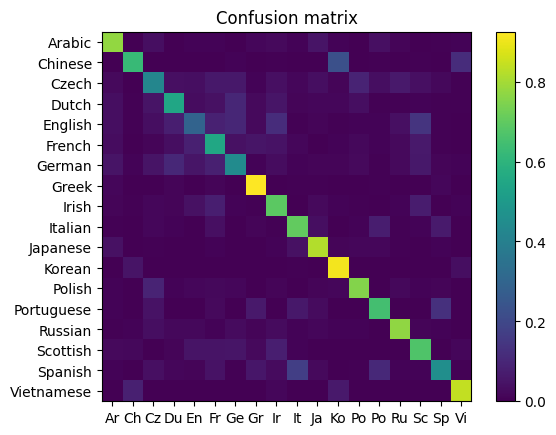

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
print(f'Accuracy: {100*accuracy/len(dataset):.2f}%')

# Normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')

# Set up labels
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

### Conclusion

Accuracy on the dataset is ~60%; this is much better than taking a random guess (which will have an accuracy of ~5.5%).

You can do you own experiences to improve this result (add layers, test other layers such as LSTM or GRU, try some combinations).

You can also change dataset (eg: word -> language; name -> gender; title -> newspaper; etc...)

This RNN exercise was inspired from the following notebook of the official PyTorch documentation:
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html